# Imports

In [1]:
from math import sin, pi
import numpy as np
from numpy import arange, argmax, asarray, vstack
from numpy.random import normal, random
from scipy.stats import norm
from matplotlib import pyplot as plt
from warnings import catch_warnings, simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Define underlying objective function (with included the unavoidable sampling noise)

In [2]:
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return x**2+ sin(5*pi*x) + noise

# Plot underlying objective function, as well as noise samples from objective function

Optima: x=0.910, y=1.816


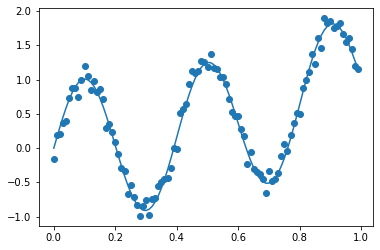

In [3]:
X = arange(0,1,0.01)
y = [objective(x,0) for x in X]
ynoise = [objective(x) for x in X]
ix = argmax(y)
print("Optima: x=%.3f, y=%.3f" % (X[ix], y[ix]))
plt.scatter(X,ynoise)
plt.plot(X,y)
plt.show()

# Define surrogate function

In [4]:
def surrogate(model, X):
    with catch_warnings():
        simplefilter("ignore")
        return model.predict(X, return_std=True)

# Plot function

In [48]:
def plot(X, y, model):
    plt.scatter(X,y)
    Xsamples = asarray(arange(0,2,0.001))
    ysamples, std = surrogate(model, Xsamples.reshape(len(Xsamples),1))
    print(std.max())
    plt.plot(Xsamples, ysamples)
    plt.fill_between(
        Xsamples,
        ysamples.ravel() - 1.96 * std,
        ysamples.ravel() + 1.96 * std,
        alpha=0.5
    )

    # X = np.sort(X.ravel())
    # mu, std = surrogate(model, X.reshape(len(X),1))
    # plt.plot(Xsamples, ysamples)
    # plt.fill_between(
    #     np.sort(X.ravel()),
    #     mu.ravel() - 1.96 * 1,
    #     mu.ravel() + 1.96 * 1,
    #     alpha=0.5
    # )
    plt.show()

### run

0.0003288207364418348


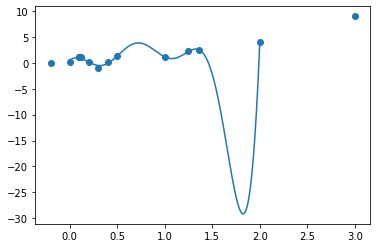

In [52]:
X = np.array([-0.2,0,0.1,0.1,0.12,1.25,1.36,0.2,0.3,0.4,0.5,1,2,3])
y = asarray([objective(x) for x in X])
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)

kernel = 0.01 * RBF(0.005)
model = GaussianProcessRegressor() # takes kernel as input, but defaults to RBF kernel
                                   # the surrogate function is the prediciton output of the GP
model.fit(X,y)
plot(X,y,model)

# Acquisition function

In [7]:
# Probability of Improvement (PI)
def acquisition(X, Xsamples, model):
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    mu, std = surrogate(model, Xsamples)
    mu = mu[:, 0]
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

In [10]:
# Expected Improvement (EI)
def acquisition(X, Xsamples, model):
    Xi = 0.1
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    mu, std = surrogate(model, Xsamples)
    mu = mu[:, 0]
    probs = (mu - best - Xi)  *  norm.cdf( (mu - best - Xi) / (std+1E-9) ) + std * norm.pdf( (mu - best - Xi) / (std+1E-9) )
    return probs

In [9]:
# Upper Confidence Bounds (UCB)
def UCB(X, Xsamples, model):
    kappa = 1
    mu, std = surrogate(model, Xsamples)
    probs = mu + kappa * std
    return probs

# Optimal parameter: acquisition function

In [11]:
def opt_acquisition(X, y, model):
    Xsamples = random(10000)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    scores = acquisition(X,Xsamples, model)
    ix = argmax(scores)
    return Xsamples[ix, 0]

### run

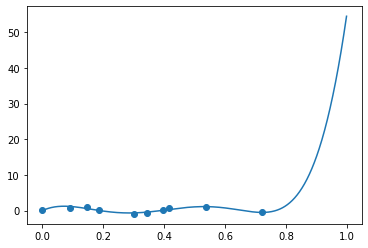

0.9998757875742624
>x=1.000, f()=54.993054, actual=0.985


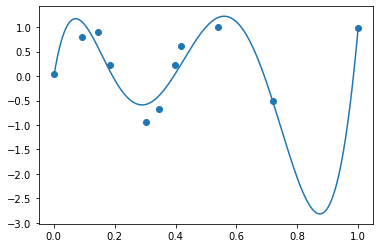

0.6789809335383882
>x=0.679, f()=0.214181, actual=-0.616


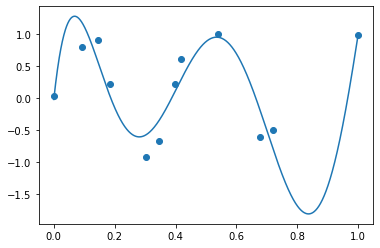

0.18291201110552435
>x=0.183, f()=0.047266, actual=0.429


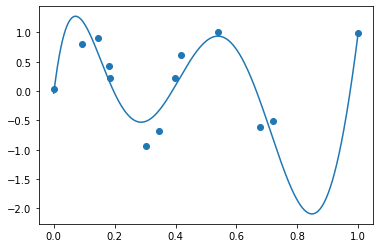

0.20843363996580866
>x=0.208, f()=-0.126471, actual=0.132


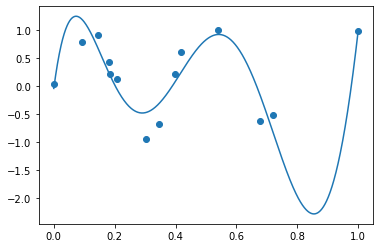

0.7773234961452496
>x=0.777, f()=-1.688139, actual=0.204


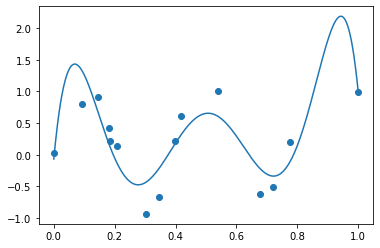

0.9431784526652282
>x=0.943, f()=2.186320, actual=1.696


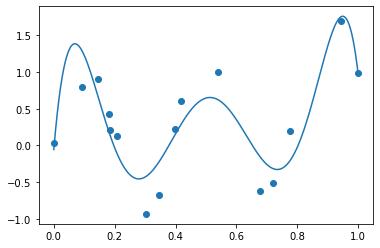

0.5948953891056719
>x=0.595, f()=0.382812, actual=0.311


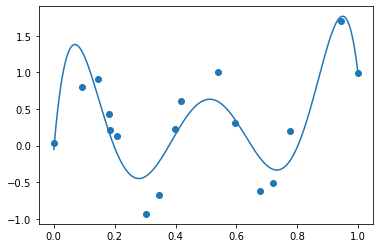

0.3558575411775712
>x=0.356, f()=-0.157175, actual=-0.522


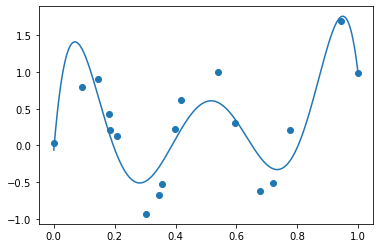

0.7792909891600704
>x=0.779, f()=-0.188478, actual=0.304


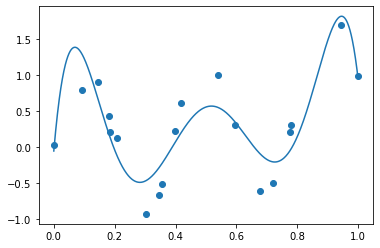

0.6495564730942379
>x=0.650, f()=0.046240, actual=-0.303


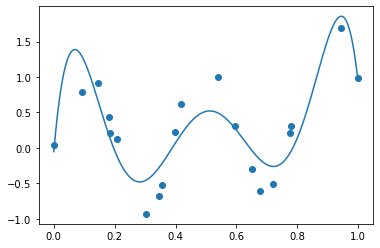

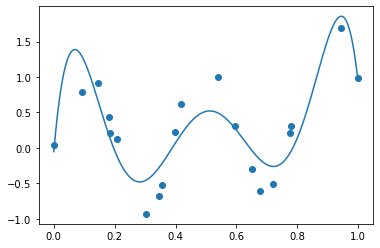

Best Result: x=0.943, y=1.696


In [13]:
np.random.seed(1)
X = np.random.rand(10)
y = asarray([objective(x) for x in X])
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)

kernel = 1 * RBF(0.005)
model = GaussianProcessRegressor() # takes kernel as input, but defaults to RBF kernel
                                   # the surrogate function is the prediciton output of the GP
model.fit(X,y)
plot(X,y,model)

for i in range(10):
    x = opt_acquisition(X,y,model)
    print(x)
    actual = objective(x)
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
    X = vstack((X,[[x]]))
    y = vstack((y,[[actual]]))
    model.fit(X,y)
    plot(X,y,model)

plot(X,y,model)
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))